<a href="https://colab.research.google.com/github/PhilipOe1612340/CVIS_DeepLearning/blob/master/exercises_02/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!mkdir data
!mkdir -p outputs/weights
!cd data
!wget http://codh.rois.ac.jp/char-shape/software/pmjt_sample_20161116.tar.gz
!tar -xvzf pmjt_sample_20161116.tar.gz
!rm pmjt_sample_20161116.tar.gz
!mv pmjt_sample_20161116/train_test_file_list.h5 data/
!rm -r pmjt_sample_20161116
!cd ..

mkdir: cannot create directory ‘data’: File exists
--2019-12-09 14:48:58--  http://codh.rois.ac.jp/char-shape/software/pmjt_sample_20161116.tar.gz
Resolving codh.rois.ac.jp (codh.rois.ac.jp)... 136.187.88.58
Connecting to codh.rois.ac.jp (codh.rois.ac.jp)|136.187.88.58|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25764925 (25M) [application/x-tar]
Saving to: ‘pmjt_sample_20161116.tar.gz’

pmjt_sample_2016111 100%[===================>]  24.57M  4.17MB/s    in 7.1s    

2019-12-09 14:49:05 (3.48 MB/s) - ‘pmjt_sample_20161116.tar.gz’ saved [25764925/25764925]

pmjt_sample_20161116/
pmjt_sample_20161116/load.pyc
pmjt_sample_20161116/run.py
pmjt_sample_20161116/config.pyc
pmjt_sample_20161116/load.py
pmjt_sample_20161116/train_test_file_list.h5
pmjt_sample_20161116/config.py
pmjt_sample_20161116/readme.md
data  output  outputs  sample_data


In [0]:
import tensorflow as tf
import numpy as np
import os
import h5py
import matplotlib.pyplot as plt



In [0]:
loadFromFile = True

def weight_variable(shape, trainable, init):
    if os.path.exists(init) and loadFromFile:
        vals = np.load(init)
    else:
        vals = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(vals, trainable=trainable)


def bias_variable(shape, trainable, init):
    if os.path.exists(init) and loadFromFile:
        vals = np.load(init)
    else:
        vals = 0.1 * np.zeros(shape, dtype=np.float32)
    return tf.Variable(vals, trainable=trainable)


def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')


def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')


def batch(X, d, batch_size):
    permutation = np.random.randint(0, X.shape[0], batch_size)
    return X[permutation, ...], d[permutation, ...]


def normalize(X):
    for i in range(X.shape[0]):
        # zero mean
        X[i, ...] = X[i, ...] - np.mean(X[i, ...].ravel())
        X[i, ...] = X[i, ...] / np.std(X[i, ...].ravel())
    return X

In [0]:
'''
LOAD
'''
file = h5py.File('./data/train_test_file_list.h5')

In [17]:
# training data

X_train = file['train_x'][()]
d_train = file['train_y'][()]

n_classes = np.unique(d_train).size
d_train = (np.arange(n_classes) == d_train).astype(np.float32)
n_train, H, W = X_train.shape  # getting the size information
X_train = X_train.reshape((-1, H, W, 1)).astype(np.float32)  # reshape to a n_train x H*W vector
X_train = normalize(X_train)

# test data
X_test = file['test_x'][()]
d_test = file['test_y'][()]
n_test, _, _ = X_test.shape
d_test = (np.arange(n_classes) == d_test).astype(np.float32)
X_test = X_test.reshape((n_test, H * W)).astype(np.float32)
X_test = normalize(X_test)

print(X_train.shape)
print(X_test.shape)

(19909, 28, 28, 1)
(3514, 784)


In [0]:
n_iter = 100
batch_size = 500

In [18]:
'''
TENSORFLOW 
'''
x = tf.placeholder(np.float32)
x_image = tf.reshape(x, [-1, 28, 28, 1])
d = tf.placeholder(np.float32)

W_conv1 = weight_variable([7, 7, 1, 32], True, './outputs/weights/W_conv1.npy')
b_conv1 = bias_variable([32], True, './outputs/weights/b_conv1.npy')
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
W_conv2 = weight_variable([5, 5, 32, 16], True, './outputs/weights/W_conv2.npy')
b_conv2 = bias_variable([16], True, './outputs/weights/b_conv2.npy')
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
W_fc1 = weight_variable([7 * 7 * 16, 16], True, './outputs/weights/W_fc1.npy')
b_fc1 = bias_variable([16], True, './outputs/weights/b_fc1.npy')
h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 16])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
W_fc2 = weight_variable([16, 10], True, './outputs/weights/W_fc2.npy')
b_fc2 = bias_variable([10], True, './outputs/weights/b_fc2.npy')
net = tf.matmul(h_fc1, W_fc2) + b_fc2

sess = tf.Session()
sess.run(tf.global_variables_initializer())

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=d, logits=net))
train = tf.train.AdamOptimizer(0.001).minimize(cross_entropy)
sess.run(tf.global_variables_initializer())

accuracy = np.zeros((n_iter, 2), dtype=np.float32)
for i in range(n_iter):
    X_train_batch, d_train_batch = batch(X_train, d_train, batch_size)

    sess.run(train, feed_dict={x: X_train_batch, d: d_train_batch})

    res_test = sess.run(net, feed_dict={x: X_test, d: d_test})
    res_train = sess.run(net, feed_dict={x: X_train_batch, d: d_train_batch})

    accuracy[i, 0] = np.sum(np.sum(np.argmax(res_test, 1) == np.argmax(d_test, 1))).astype(np.float32) / X_test.shape[0]
    accuracy[i, 1] = np.sum(np.sum(np.argmax(res_train, 1) == np.argmax(d_train_batch, 1))).astype(np.float32) / \
                     X_train_batch.shape[0]
    print('Test Accuracy %.2f\t Train Accuracy %.2f' % (accuracy[i, 0], accuracy[i, 1]))

Test Accuracy 0.77	 Train Accuracy 0.79
Test Accuracy 0.83	 Train Accuracy 0.86
Test Accuracy 0.82	 Train Accuracy 0.81
Test Accuracy 0.82	 Train Accuracy 0.79
Test Accuracy 0.83	 Train Accuracy 0.82
Test Accuracy 0.84	 Train Accuracy 0.82
Test Accuracy 0.83	 Train Accuracy 0.82
Test Accuracy 0.83	 Train Accuracy 0.87
Test Accuracy 0.84	 Train Accuracy 0.86
Test Accuracy 0.84	 Train Accuracy 0.86
Test Accuracy 0.84	 Train Accuracy 0.82
Test Accuracy 0.84	 Train Accuracy 0.83
Test Accuracy 0.84	 Train Accuracy 0.88
Test Accuracy 0.84	 Train Accuracy 0.84
Test Accuracy 0.85	 Train Accuracy 0.86
Test Accuracy 0.85	 Train Accuracy 0.86
Test Accuracy 0.85	 Train Accuracy 0.87
Test Accuracy 0.85	 Train Accuracy 0.85
Test Accuracy 0.85	 Train Accuracy 0.86
Test Accuracy 0.85	 Train Accuracy 0.86
Test Accuracy 0.85	 Train Accuracy 0.85
Test Accuracy 0.85	 Train Accuracy 0.88
Test Accuracy 0.85	 Train Accuracy 0.85
Test Accuracy 0.85	 Train Accuracy 0.84
Test Accuracy 0.85	 Train Accuracy 0.85


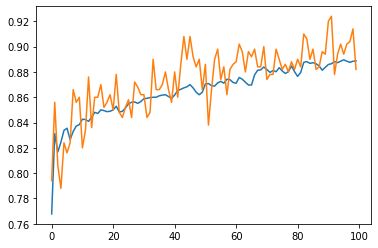

In [19]:
np.save('./outputs/accuracy', accuracy)
np.save('./outputs/weights/W_conv1', sess.run(W_conv1))
np.save('./outputs/weights/b_conv1', sess.run(b_conv1))
np.save('./outputs/weights/W_conv2', sess.run(W_conv2))
np.save('./outputs/weights/b_conv2', sess.run(b_conv2))
np.save('./outputs/weights/W_fc1', sess.run(W_fc1))
np.save('./outputs/weights/b_fc1', sess.run(b_fc1))
np.save('./outputs/weights/W_fc2', sess.run(W_fc2))
np.save('./outputs/weights/b_fc2', sess.run(b_fc2))

plt.plot(accuracy[:, 0])
plt.plot(accuracy[:, 1])
plt.show()